In [3]:
# Установка пакетов oligo, oligoData, limma, maqcExpression4plex,
# genefilter, ggplot2, ggplots
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("oligo")
BiocManager::install("oligoData")
BiocManager::install("limma")
BiocManager::install("maqcExpression4plex")
BiocManager::install("genefilter")
BiocManager::install("ggplot2")
BiocManager::install("gplots")

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'oligo'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'bit', 'bit64', 'data.table', 'dplyr', 'ff', 'GOSemSim', 'httr',
  'sys', 'tidyr'

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'oligoData'

Warning message in install.packages(...):
“installation of package ‘oligoData’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'bit', 'bit64', 'data.table', 'dplyr', 'ff', 'GOSemSim', 'httr',
  'sys', 'tidyr'

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'limma'

Warning message in install.packages(...):
“installation of package ‘limma’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [36]:
library("oligo")
library("oligoData")
# library("limma")
# library("maqcExpression4plex")
# library("genefilter")
# library('ggplot2')
# library('gplots')

In [68]:
# Получаем путь к папке с датасетом
data.dir <- system.file("extdata", package="maqcExpression4plex")

# Получаем абсолютные пути к файлам 
files.path <- oligo::list.xysfiles(data.dir, full.names=TRUE)

# Выводим только названия файлов
basename(files.path)

[1] "9868701_532.xys" "9868901_532.xys" "9869001_532.xys" "9870301_532.xys"
[5] "9870401_532.xys" "9870601_532.xys"

In [45]:
# Сами пути
files.path

[1] "/home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9868701_532.xys"
[2] "/home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9868901_532.xys"
[3] "/home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9869001_532.xys"
[4] "/home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9870301_532.xys"
[5] "/home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9870401_532.xys"
[6] "/home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9870601_532.xys"

In [47]:
# Создаем разметку для наших файлов
diseases <- c('brain',
              'brain',
              'brain',
             'universal reference',
             'universal reference',
             'universal reference'
             )

data <- data.frame(Key = diseases)
data

Key
<chr>
brain
brain
brain
universal reference
universal reference
universal reference


In [48]:
# Добавляем аннотации к файлам
rownames(data) <- basename(files.path)
data

,Key
,<chr>
9868701_532.xys,brain
9868901_532.xys,brain
9869001_532.xys,brain
9870301_532.xys,universal reference
9870401_532.xys,universal reference
9870601_532.xys,universal reference


In [6]:
# levels <- c("exprs", "_ALL_")
# MtData <- data.frame(channel=factor('exprs', levels=levels),
#                       labelDescription="Sample type")
# MtData

#pd <- new("AnnotatedDataFrame", data=data, varMetadata=MtData)

channel,labelDescription
<fct>,<chr>
exprs,Sample type


In [63]:
# Создаем новый экземпляр AnnotatedDataFrame
# Он нужен для того, чтобы сопоставить файл к классу
pd <- Biobase::AnnotatedDataFrame(data = data)
pd

An object of class 'AnnotatedDataFrame'
  rowNames: 9868701_532.xys 9868901_532.xys ... 9870601_532.xys (6
    total)
  varLabels: Key
  varMetadata: labelDescription

In [64]:
# Читаем xys файлы
maqc <- oligo::read.xysfiles(files.path, phenoData = pd)

# Выводим объект 
maqc

Platform design info loaded.



Checking designs for each XYS file... Done.
Allocating memory... Done.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9868701_532.xys.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9868901_532.xys.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9869001_532.xys.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9870301_532.xys.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9870401_532.xys.
Reading /home/mark/anaconda3/envs/r-enviroment/lib/R/library/maqcExpression4plex/extdata/9870601_532.xys.


Warning message in oligo::read.xysfiles(files.path, phenoData = pd):
“'channel' automatically added to varMetadata in phenoData.”


ExpressionFeatureSet (storageMode: lockedEnvironment)
assayData: 76774 features, 6 samples 
  element names: exprs 
protocolData
  rowNames: 9868701_532.xys 9868901_532.xys ... 9870601_532.xys (6
    total)
  varLabels: exprs dates
  varMetadata: labelDescription channel
phenoData
  rowNames: 9868701_532.xys 9868901_532.xys ... 9870601_532.xys (6
    total)
  varLabels: Key
  varMetadata: labelDescription channel
featureData: none
experimentData: use 'experimentData(object)'
Annotation: pd.hg18.60mer.expr 

In [72]:
# Смотрим на данные
Biobase::exprs(maqc)[10001:10010,]

,9868701_532.xys,9868901_532.xys,9869001_532.xys,9870301_532.xys,9870401_532.xys,9870601_532.xys
10001,734.67,742.22,636.22,208.33,223.78,184.44
10002,4786.11,4434.67,4068.11,2077.44,1953.00,2128.78
10003,25600.33,26154.89,23522.67,1320.44,1306.89,1266.78
10004,1078.56,1092.78,883.89,1864.00,1827.33,1871.67
10005,3056.44,3128.33,2640.67,1607.22,1540.11,1657.78
10006,310.22,385.00,387.78,619.33,592.67,576.44
10007,NA,NA,NA,NA,NA,NA
10008,NA,NA,NA,NA,NA,NA
10009,599.44,713.00,613.22,2217.89,1967.33,1841.67
10010,28711.67,29794.67,29411.33,9014.00,7955.44,9017.78


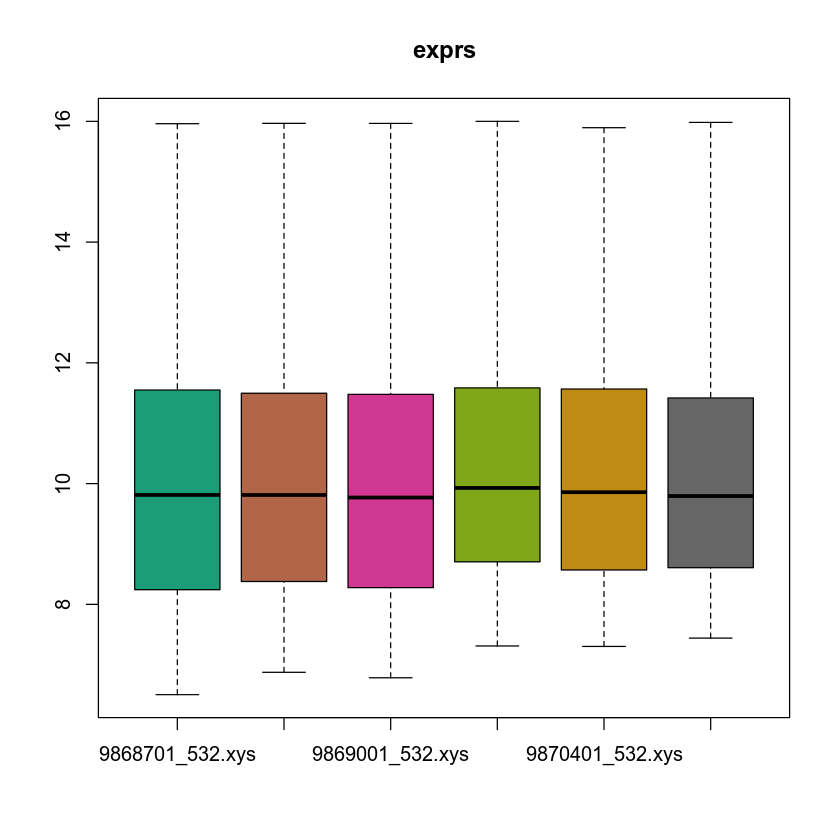

In [76]:
oligo::boxplot(maqc)

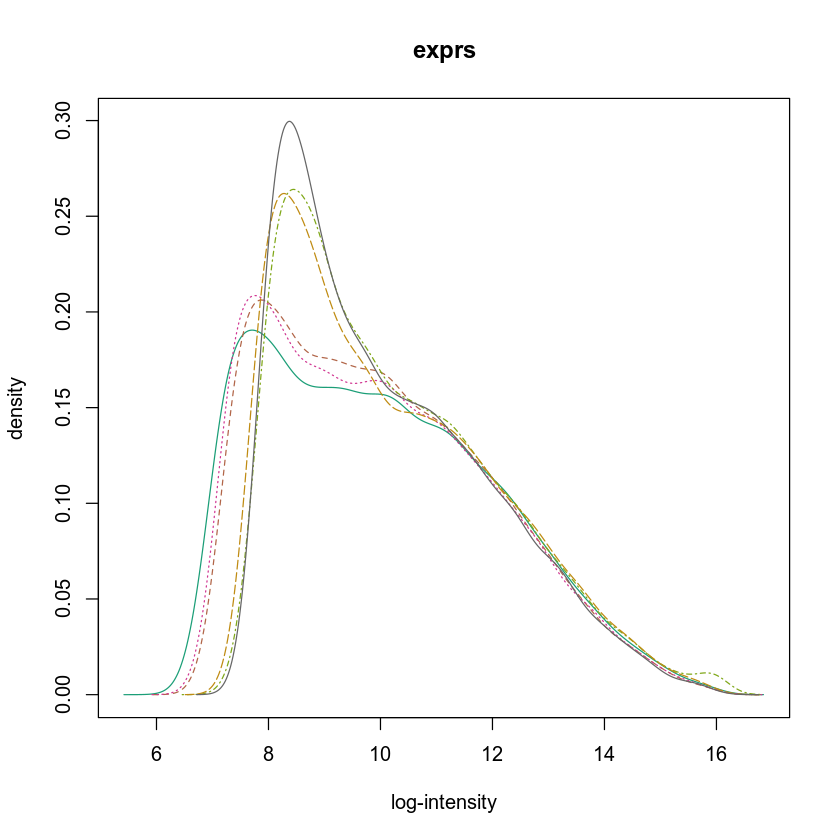

In [75]:
oligo::hist(maqc)

ERROR: Error: 'legend' is not an exported object from 'namespace:oligo'


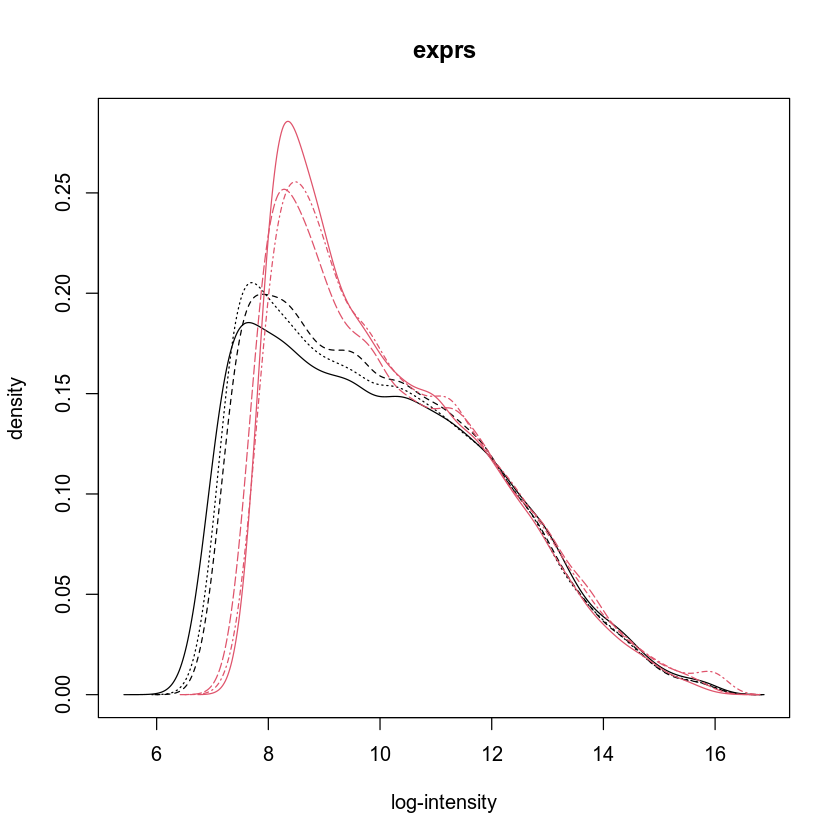

In [88]:
# гистограмма по классам
oligo::hist(maqc, col=c(1, 1, 1, 2, 2, 2))

In [54]:
# Нормализуем данные с помощью RMA
eset <- oligo::rma(maqc)

Background correcting
Normalizing
Calculating Expression


In [89]:
exprs(eset)[10001:10010, 1:2]

,9868701_532.xys,9868901_532.xys
NM_014275,10.26541,10.367936
NM_014276,6.35906,6.391927
NM_014278,11.88073,11.862970
NM_014279,14.92681,14.890158
NM_014280,11.73407,11.572199
NM_014281,10.55036,10.488262
NM_014282,14.35916,14.343109
NM_014283,10.30147,10.189285
NM_014285,10.78391,10.731717
NM_014286,14.37042,14.262307


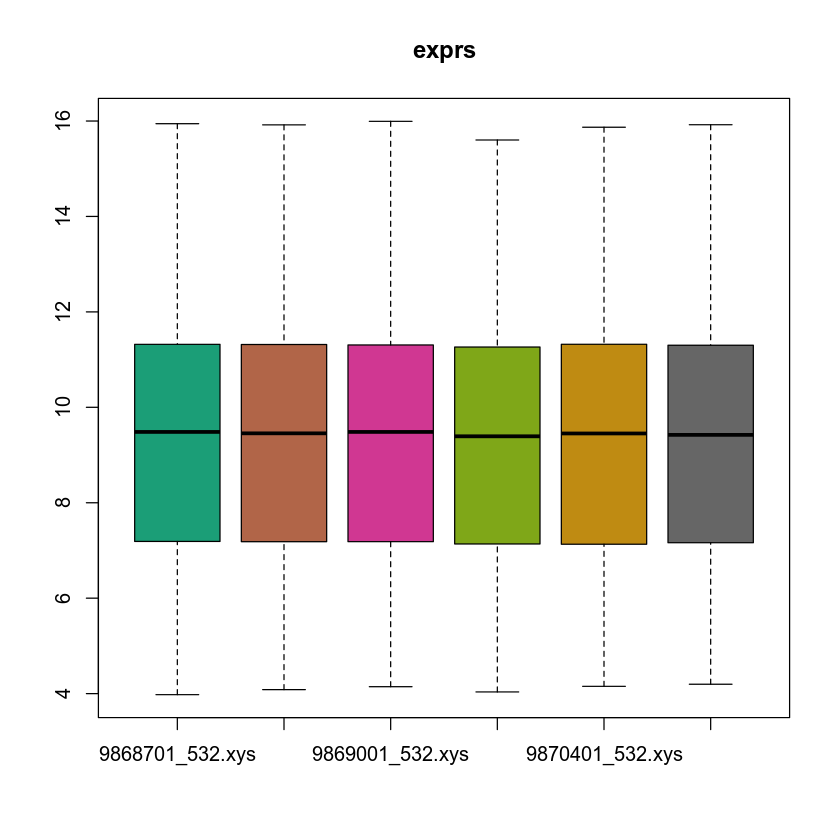

In [90]:
boxplot(eset)

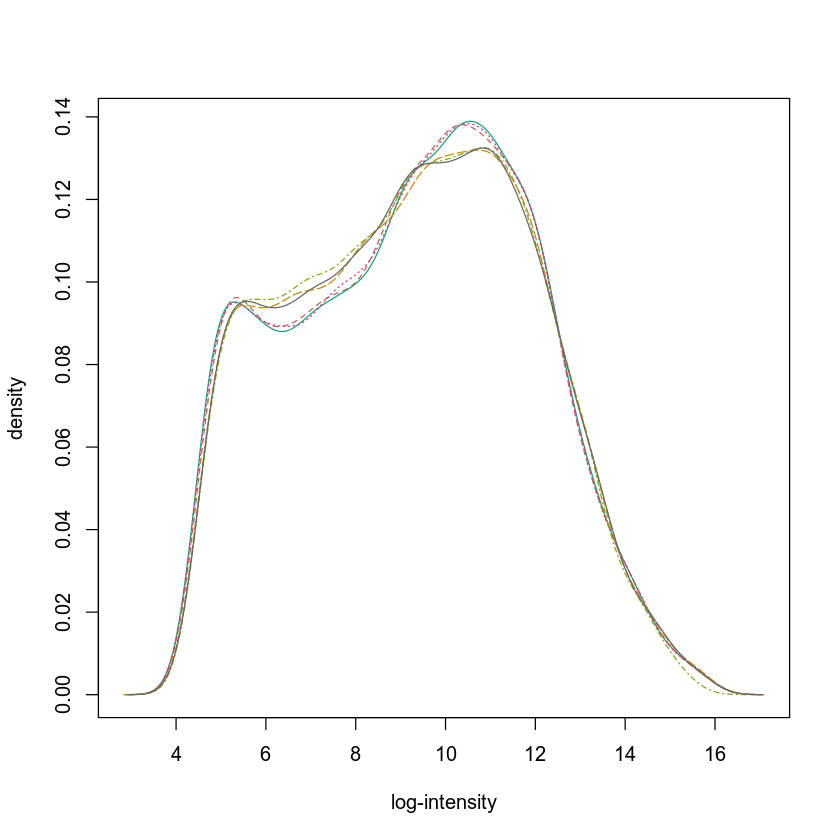

In [91]:
hist(eset)

In [92]:
# Получаем экспрессию генов и ее логарифмируем
exprs.data = log2(exprs(eset))

In [106]:
# Вычисляем PCA c помощью функции prcomp
# Функция t транспонирует матрицу
PCA_raw <- prcomp(t(exprs.data), scale. = FALSE)
summary(PCA_raw)

Importance of components:
                           PC1     PC2     PC3     PC4     PC5       PC6
Standard deviation     25.8455 3.24970 2.83913 2.60108 2.38587 2.273e-14
Proportion of Variance  0.9555 0.01511 0.01153 0.00968 0.00814 0.000e+00
Cumulative Proportion   0.9555 0.97065 0.98218 0.99186 1.00000 1.000e+00

In [107]:
# Вычисляем среденее отклонение по каждому вектору
se <- PCA_raw$sdev^2
percentVar <- round(100 * se / sum(se), 1)
percentVar

[1] 95.6  1.5  1.2  1.0  0.8  0.0

In [108]:
dataGG <- data.frame(PC1 = PCA_raw$x[,1], PC2 = PCA_raw$x[,2])
dataGG

,PC1,PC2
,<dbl>,<dbl>
9868701_532.xys,-23.75448,0.032443477
9868901_532.xys,-23.47149,-2.150982606
9869001_532.xys,-23.55389,2.133879435
9870301_532.xys,23.41515,-4.682633711
9870401_532.xys,23.75610,0.009557786
9870601_532.xys,23.60860,4.657735619


In [109]:
colnames(eset)

[1] "9868701_532.xys" "9868901_532.xys" "9869001_532.xys" "9870301_532.xys"
[5] "9870401_532.xys" "9870601_532.xys"

In [110]:
data

,Key
,<chr>
9868701_532.xys,brain
9868901_532.xys,brain
9869001_532.xys,brain
9870301_532.xys,universal reference
9870401_532.xys,universal reference
9870601_532.xys,universal reference


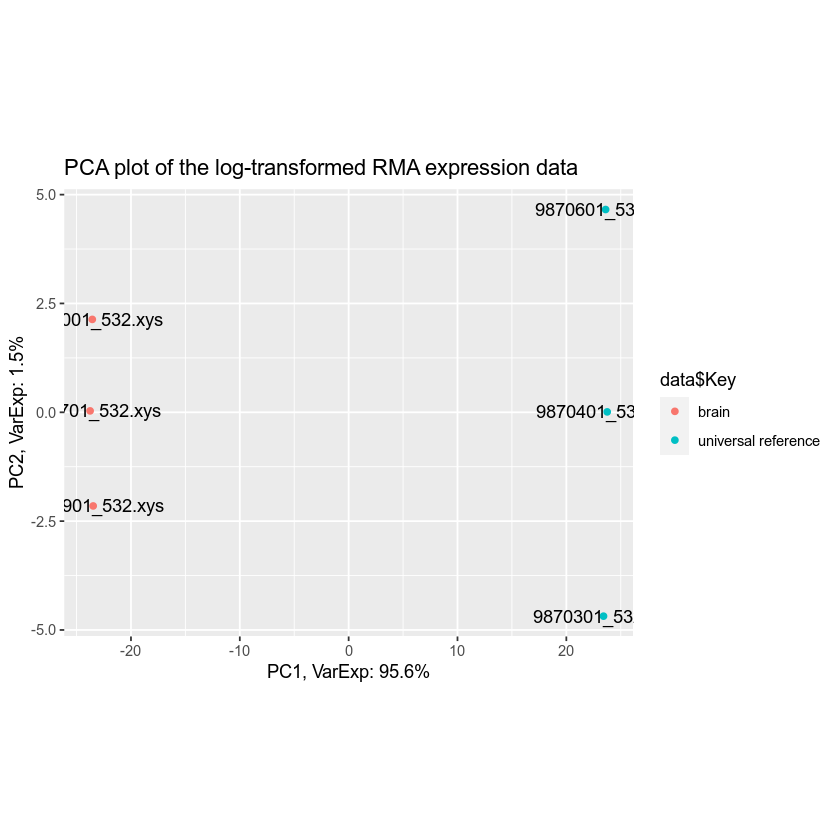

In [105]:
# Выводим PCA
# В основном все функции, которые написаны в этом блоке
# относятся к пакету ggplot2

ggplot(dataGG, aes(PC1, PC2)) +
geom_point(aes(colour = data$Key)) +
geom_text(label = colnames(eset)) +
ggtitle("PCA plot of the log-transformed RMA expression data") + 
xlab(paste0("PC1, VarExp: ", percentVar[1], "%")) + 
ylab(paste0("PC2, VarExp: ", percentVar[2], "%")) +
coord_fixed(ratio = 4)

### Heatmap, CLustermap

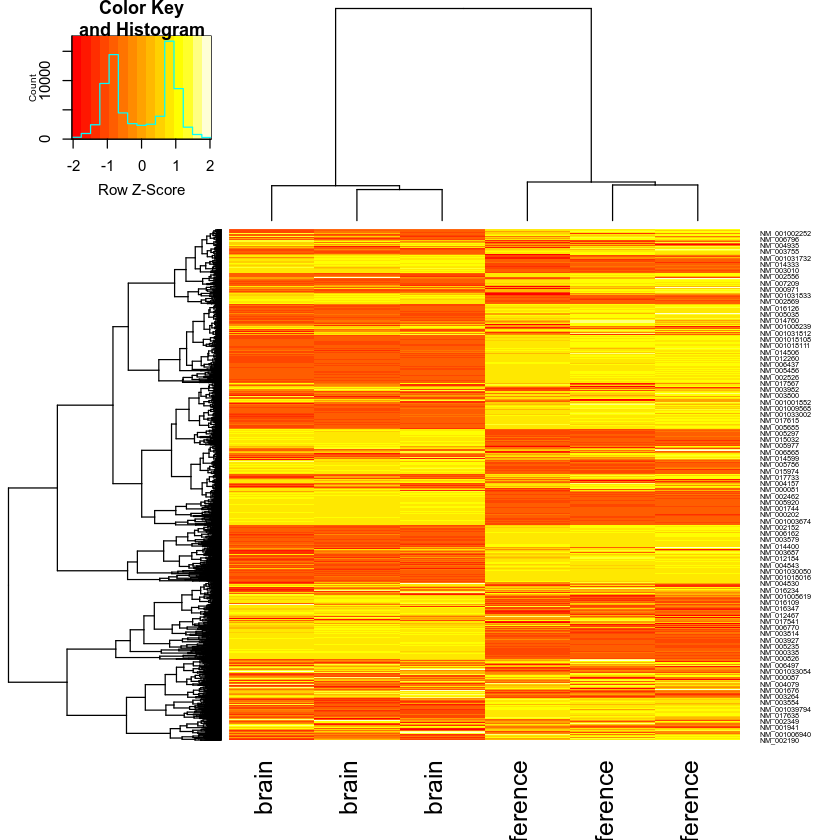

In [114]:
# Сократим кол-во данных, чтобы не занимать много памяти
s <- exprs.data[1:12000, 1:6]
colnames(s) <- data$Key

# С помощью heatmap.2.строим Clustermap
# trace='none' нужен для того, чтобы не выводить голубую линию
heatmap.2(s, scale='row', trace='none')